## Import packages

In [9]:
import xarray as xr
from scipy.stats import linregress
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Read, select and convert Units of the Data

In [2]:
DATADIR = './'
monthly_data = f'{DATADIR}era5_monthly_t2m_eur.nc'

data = xr.open_dataset(monthly_data)

temp_data = xr.DataArray(data['t2m'])
tp_data = xr.DataArray(data['tp']).rename('Niederschlag mm')

temp_data_combine = temp_data.sel(expver=1).combine_first(temp_data.sel(expver=5))
tp_data_combine = tp_data.sel(expver=1).combine_first(tp_data.sel(expver=5))


# Convert Kelvin to Celcius
temp_data_degc = temp_data_combine - 273.15
temp_data_degc = temp_data_degc.assign_attrs(temp_data_combine.attrs)
temp_data_degc.attrs['units'] = '°C'


# Convert precipitation from meters to millimeters
tp_data_mm = tp_data_combine * 1000
tp_data_mm.attrs['units'] = 'mm'



In [3]:
# Selecting only July months across all years
july_data = temp_data_degc.where(temp_data_degc['time.month'] == 7, drop=True)


# Group by year and calculate the mean for each July
july_annual_means = july_data.groupby('time.year').mean(dim='time')
july_annual_means

# Selecting only July months across all years
july_data_precip = tp_data_mm.where(tp_data_mm['time.month'] == 7, drop=True)


# Group by year and calculate the mean for each July
july_annual_means_precip = july_data_precip.groupby('time.year').mean(dim='time')
july_annual_means_precip

<xarray.DataArray 'Niederschlag mm' (year: 33, latitude: 381, longitude: 651)>
array([[[4.3193436e-01, 4.3193436e-01, 4.1950679e-01, ...,
                   nan,           nan,           nan],
        [4.9072504e-01, 4.7590768e-01, 4.6109036e-01, ...,
                   nan,           nan,           nan],
        [5.4856014e-01, 5.2848554e-01, 5.0076282e-01, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         8.0093741e-04, 8.0093741e-04, 8.0093741e-04],
        [          nan,           nan,           nan, ...,
         8.0093741e-04, 8.0093741e-04, 8.0093741e-04],
        [          nan,           nan,           nan, ...,
         8.0093741e-04, 8.0093741e-04, 8.0093741e-04]],

       [[6.1930066e-01, 5.9970373e-01, 5.6815708e-01, ...,
                   nan,           nan,           nan],
        [6.7856908e-01, 6.4128733e-01, 6.0400552e-01, ...,
                   nan,           nan,           nan],
        [7.2780067e-01, 6.8334866e-01, 6.3172728e-01, ...,
                   nan,           nan,           nan],
...
        [          nan,           nan,           nan, ...,
         1.2777746e-03, 1.2777746e-03, 1.2777746e-03],
        [          nan,           nan,           nan, ...,
         1.2777746e-03, 1.2777746e-03, 1.2777746e-03],
        [          nan,           nan,           nan, ...,
         1.2777746e-03, 1.2777746e-03, 1.2777746e-03]],

       [[8.4777272e-01, 8.4729397e-01, 8.3486736e-01, ...,
                   nan,           nan,           nan],
        [7.7989978e-01, 7.7273047e-01, 7.6508242e-01, ...,
                   nan,           nan,           nan],
        [7.1967489e-01, 7.1250552e-01, 6.9912243e-01, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         3.2223761e-04, 3.2223761e-04, 3.2223761e-04],
        [          nan,           nan,           nan, ...,
         3.2223761e-04, 3.2223761e-04, 3.2223761e-04],
        [          nan,           nan,           nan, ...,
         3.2223761e-04, 3.2223761e-04, 3.2223761e-04]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.9 -24.8 -24.7 ... 39.8 39.9 40.0
  * latitude   (latitude) float32 72.0 71.9 71.8 71.7 ... 34.3 34.2 34.1 34.0
  * year       (year) int64 1991 1992 1993 1994 1995 ... 2020 2021 2022 2023
Attributes:
    units:    mm

## Create Function to calculate Trends

In [4]:
def calculate_trend(data):
    years = np.arange(data['year'].values[0], data['year'].values[-1] + 1)
    
    # Initialize arrays to store slope, p-value, standard error, and R²
    slopes = np.full(data.shape[1:], np.nan)
    p_values = np.full(data.shape[1:], np.nan)
    std_errs = np.full(data.shape[1:], np.nan)
    r_squared = np.full(data.shape[1:], np.nan)

    # Iterate over each pixel
    for lat in range(data.shape[1]):
        for lon in range(data.shape[2]):
            y = data[:, lat, lon]
            
            # Check for sufficient non-NaN data
            if np.count_nonzero(~np.isnan(y)) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                
                slopes[lat, lon] = slope
                p_values[lat, lon] = p_value
                std_errs[lat, lon] = std_err
                r_squared[lat, lon] = r_value ** 2  # R² value

    return slopes, p_values, std_errs, r_squared


In [5]:
# Calculate trends for temperature
temp_trends = calculate_trend(july_annual_means)

# Calculate trends for precipitation
precip_trends = calculate_trend(july_annual_means_precip)


In [10]:
# Extract the components for temperature trends
temp_slopes, temp_p_values, temp_std_errs, temp_r_squared = temp_trends

# Extract the components for precipitation trends
precip_slopes, precip_p_values, precip_std_errs, precip_r_squared = precip_trends

# For temperature trends
temp_slopes_da = xr.DataArray(temp_slopes, dims=dims, coords=coords)
temp_p_values_da = xr.DataArray(temp_p_values, dims=dims, coords=coords)
temp_std_errs_da = xr.DataArray(temp_std_errs, dims=dims, coords=coords)
temp_r_squared_da = xr.DataArray(temp_r_squared, dims=dims, coords=coords)

# For precipitation trends
precip_slopes_da = xr.DataArray(precip_slopes, dims=dims, coords=coords)
precip_p_values_da = xr.DataArray(precip_p_values, dims=dims, coords=coords)
precip_std_errs_da = xr.DataArray(precip_std_errs, dims=dims, coords=coords)
precip_r_squared_da = xr.DataArray(precip_r_squared, dims=dims, coords=coords)

# Combine into separate Datasets
temp_combined_ds = xr.Dataset({
    'slope': temp_slopes_da,
    'p_value': temp_p_values_da,
    'std_err': temp_std_errs_da,
    'r_squared': temp_r_squared_da
})

precip_combined_ds = xr.Dataset({
    'slope': precip_slopes_da,
    'p_value': precip_p_values_da,
    'std_err': precip_std_errs_da,
    'r_squared': precip_r_squared_da
})


In [14]:
# Convert Datasets to DataFrames
temp_df = temp_combined_ds.to_dataframe().reset_index()
precip_df = precip_combined_ds.to_dataframe().reset_index()

# Create point geometries for temperature and precipitation DataFrames
temp_df['geometry'] = temp_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
precip_df['geometry'] = precip_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrames
temp_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')
precip_gdf = gpd.GeoDataFrame(precip_df, geometry='geometry')

# Save to file (GeoPackage format)
temp_gdf.to_file('temp_gdf.gpkg', layer='temp', driver='GPKG')
precip_gdf.to_file('precip_gdf.gpkg', layer='precip', driver='GPKG')


## Visualization of Temperature Trends & P-Values

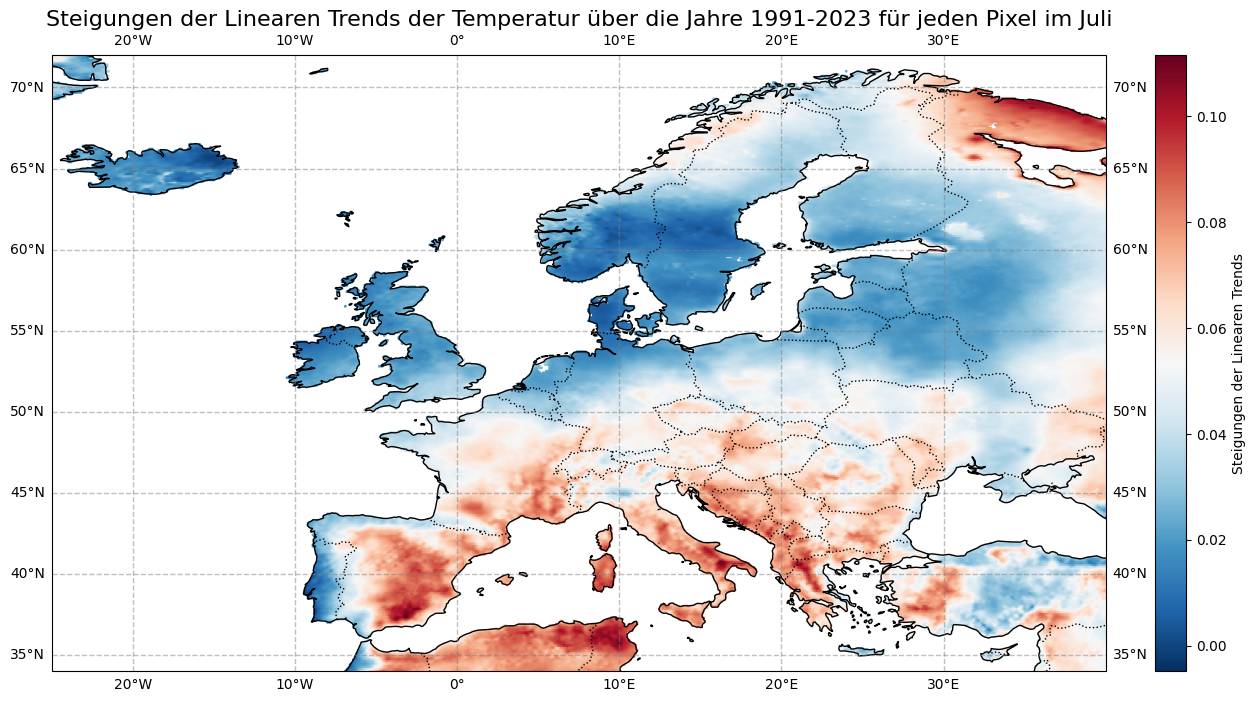

In [44]:
# Get Values from GeoDataFrame
lons_temp = temp_gdf['longitude'].values
lats_temp = temp_gdf['latitude'].values
trends_temp = temp_gdf['slope'].values  # the 'slope' column represents the trend

fig, ax = plt.subplots(1, 1, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a scatter plot of trends
scatter = ax.scatter(lons_temp, lats_temp, c=trends_temp,s=1, cmap='RdBu_r', marker='o', transform=ccrs.PlateCarree())

# Add features to the map
ax.set_title('Steigungen der Linearen Trends der Temperatur über die Jahre 1991-2023 für jeden Pixel im Juli', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines(color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Steigungen der Linearen Trends')

# Save plot
fig.savefig(f'{DATADIR}ERA5_Europe_2023-07_linear_Trends_Temp.png')

plt.show()


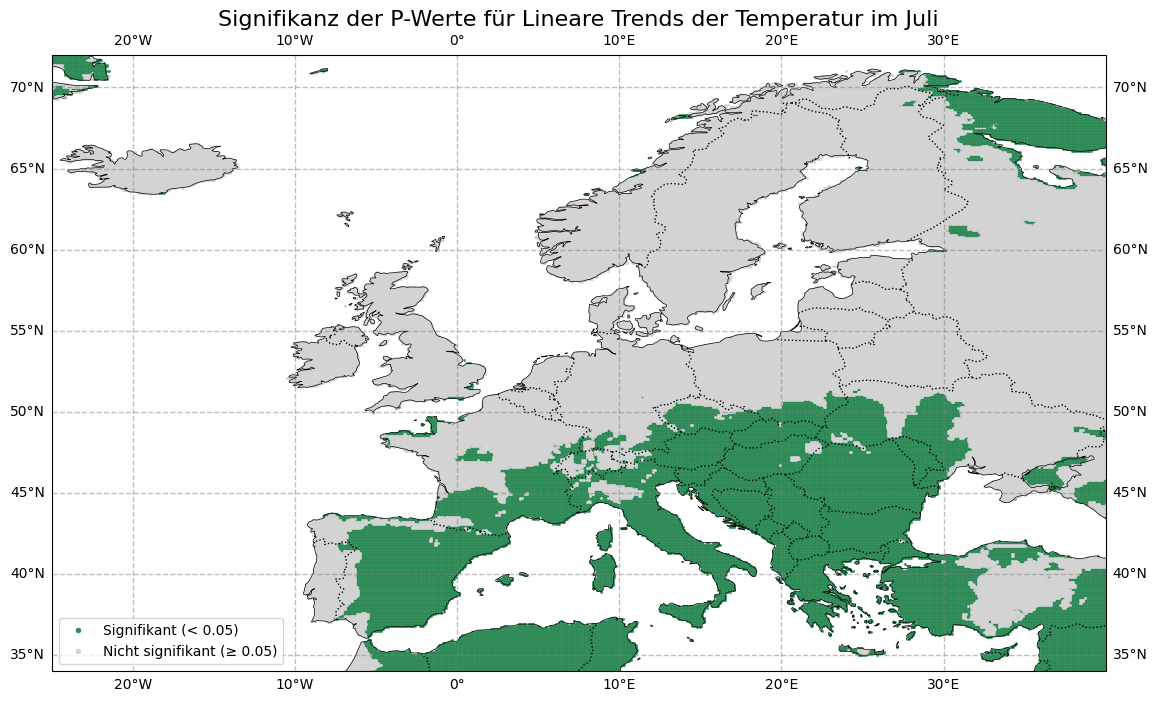

In [39]:
# Filter out any NaN values if they exist
temp_gdf_nona = temp_gdf.dropna(subset=['p_value'])

# Get Values from filtered GeoDataFrame
lons_temp = temp_gdf_nona['longitude'].values
lats_temp = temp_gdf_nona['latitude'].values
pvalue_temp = temp_gdf_nona['p_value'].values

# Create a boolean array for points that are significant (where p-value is below 0.05)
significant_points = pvalue_temp < 0.05

fig, ax = plt.subplots(1, 1, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot significant points in one color and non-significant in another
ax.scatter(lons_temp[significant_points], lats_temp[significant_points], c='seagreen', s=1, marker='o', transform=ccrs.PlateCarree())
ax.scatter(lons_temp[~significant_points], lats_temp[~significant_points], c='lightgrey', s=1, marker='o', transform=ccrs.PlateCarree())

# Add features to the map
ax.set_title('Signifikanz der P-Werte für Lineare Trends der Temperatur im Juli', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')  # Set ocean facecolor to white
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Add a legend
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='seagreen', markersize=5, label='Signifikant (< 0.05)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=5, label='Nicht signifikant (≥ 0.05)')
]
ax.legend(handles=legend_labels, loc='lower left')

# Save plot
fig.savefig(f'{DATADIR}ERA5_Europe_2023-07_linear_Trends_Temp_pvalue.png')

plt.show()


## Visualization of Precipitation Trends & P-Values

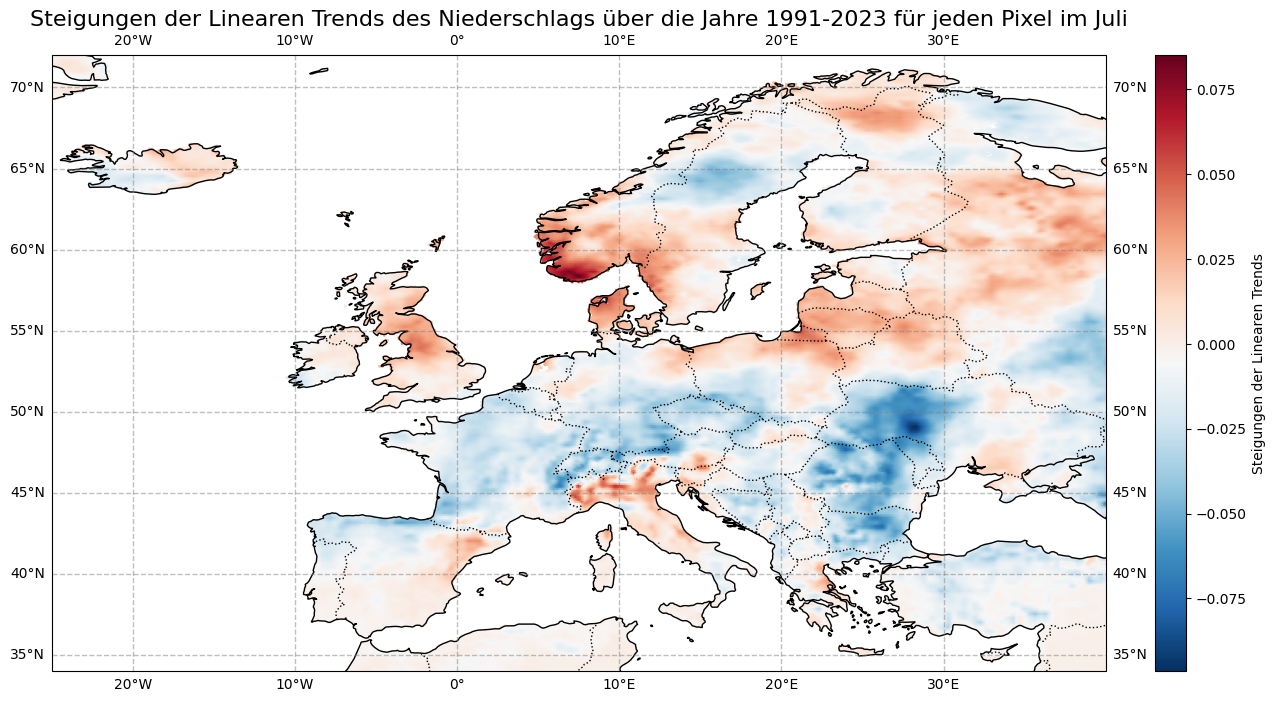

In [43]:
# Get Values from GeoDataFrame
lons_prec = precip_gdf['longitude'].values
lats_prec = precip_gdf['latitude'].values
trends_prec = precip_gdf['slope'].values  # the 'slope' column represents the trend

fig, ax = plt.subplots(1, 1, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Create a scatter plot of trends
scatter = ax.scatter(lons_prec, lats_prec, c=trends_prec,s=1, cmap='RdBu_r', marker='o', transform=ccrs.PlateCarree())

# Add features to the map
ax.set_title('Steigungen der Linearen Trends des Niederschlags über die Jahre 1991-2023 für jeden Pixel im Juli', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines(color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Steigungen der Linearen Trends')

# Save plot
fig.savefig(f'{DATADIR}ERA5_Europe_2023-07_linear_Trends_Precip.png')


plt.show()


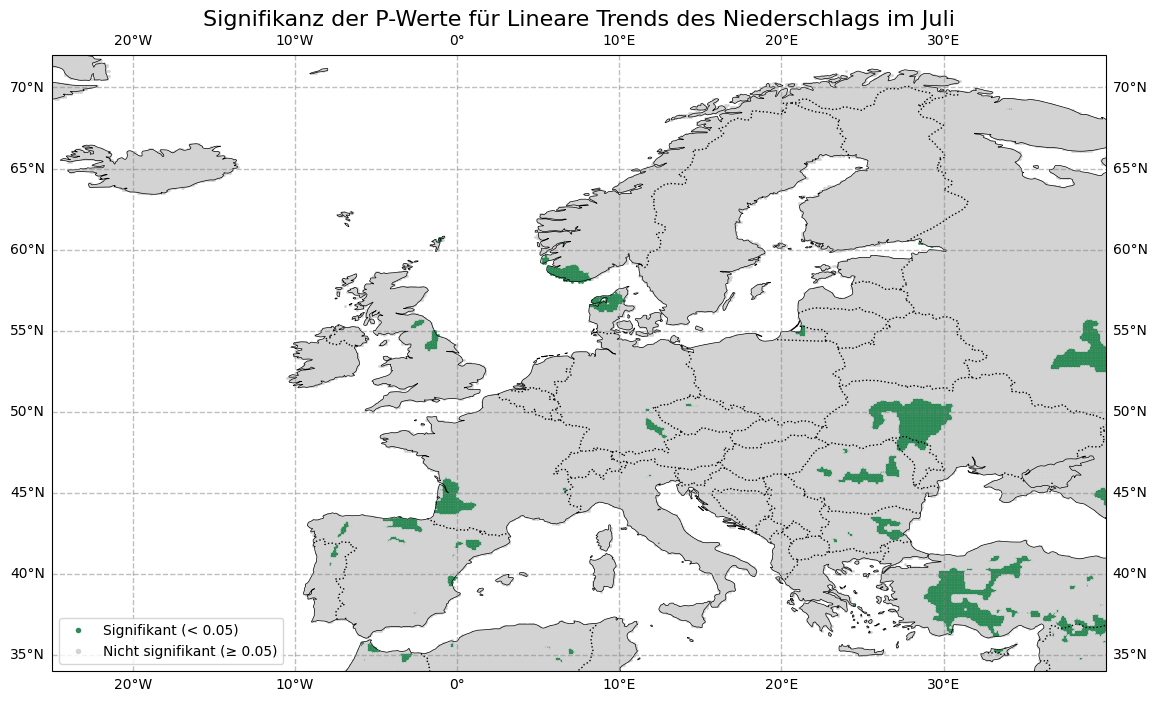

In [42]:
#Filter out any NaN values if they exist
precip_gdf_nona = precip_gdf.dropna(subset=['p_value'])

# Get Values from filtered GeoDataFrame
lons_prec = precip_gdf_nona['longitude'].values
lats_prec = precip_gdf_nona['latitude'].values
pvalue_prec = precip_gdf_nona['p_value'].values

# Create a boolean array for points that are significant (where p-value is below 0.05)
significant_points = pvalue_prec < 0.05

fig, ax = plt.subplots(1, 1, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot significant points in one color and non-significant in another
ax.scatter(lons_prec[significant_points], lats_prec[significant_points], c='seagreen', s=1, marker='o', transform=ccrs.PlateCarree())
ax.scatter(lons_prec[~significant_points], lats_prec[~significant_points], c='lightgrey', s=1, marker='o', transform=ccrs.PlateCarree())

# Add features to the map
ax.set_title('Signifikanz der P-Werte für Lineare Trends des Niederschlags im Juli', fontsize=16)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')  # Set ocean facecolor to white
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

# Add a legend
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='seagreen', markersize=5, label='Signifikant (< 0.05)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=5, label='Nicht signifikant (≥ 0.05)')
]
ax.legend(handles=legend_labels, loc='lower left')

# Save plot
fig.savefig(f'{DATADIR}ERA5_Europe_2023-07_linear_Trends_Precip_pvalue.png')

plt.show()


## Calculate Trends for each Country

In [30]:
temp_gdf = gpd.read_file('temp_gdf.gpkg', layer='temp')
precip_gdf =gpd.read_file('precip_gdf.gpkg', layer='precip')

# Load the country shapefile
countries_gdf = gpd.read_file('ne_50m_admin_0_countries.shp')


In [17]:
# Reproject climate data to match the CRS of the country shapefile
temp_gdf = temp_gdf.set_crs(epsg=4326, allow_override=True)
precip_gdf = precip_gdf.set_crs(epsg=4326, allow_override=True)

# Join Datasets
temp_with_countries = gpd.sjoin(temp_gdf, countries_gdf, how='inner', predicate='intersects')
precip_with_countries = gpd.sjoin(precip_gdf, countries_gdf, how='inner', predicate='intersects')
   

In [20]:
#Temp
# Assuming 'temp_with_countries' is a DataFrame that includes country names and the additional metrics
country_temp_stats = temp_with_countries[['SOVEREIGNT', 'slope', 'p_value', 'std_err', 'r_squared']].groupby('SOVEREIGNT').mean()

# Renaming the index 'SOVEREIGNT' to 'Country'
country_temp_stats.index.rename('Country', inplace=True)

# Flatten the MultiIndex
country_temp_stats = country_temp_stats.reset_index()


In [41]:
#Precip
# Assuming 'precip_with_countries' includes the additional metrics
country_precip_stats = precip_with_countries[['SOVEREIGNT', 'slope', 'p_value', 'std_err', 'r_squared']].groupby('SOVEREIGNT').mean()

# Renaming the index 'SOVEREIGNT' to 'Country'
country_precip_stats.index.rename('Country', inplace=True)

# Flatten the MultiIndex
country_precip_stats = country_precip_stats.reset_index()



In [51]:
temp_summary_stats_country = country_temp_stats[['slope', 'p_value', 'std_err', 'r_squared']].describe()
precip_summary_stats_country = country_precip_stats[['slope', 'p_value', 'std_err', 'r_squared']].describe()

### Join CSV-Agriculture Dataset

In [57]:
# Load the provided CSV files
ag_land_df = pd.read_csv('API_AG.LND.AGRI.ZS_DS2_en_csv_v2_6299921.csv', skiprows=4)
ag_gdp_df = pd.read_csv('API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_6299253.csv', skiprows=4)


country_name_mapping = {
    'Czech Republic': 'Czechia',
    'Macedonia, FYR': 'North Macedonia',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syria',
    'Serbia': 'Republic of Serbia',
    'Turkiye': 'Turkey'
    # Add other mappings as necessary
}

# Apply the mapping to standardize names in the agriculture DataFrames
ag_land_df['Country Name'] = ag_land_df['Country Name'].replace(country_name_mapping)
ag_gdp_df['Country Name'] = ag_gdp_df['Country Name'].replace(country_name_mapping)

# Extracting the relevant columns (most recent year data - 2021) from the agriculture data
ag_land_2021 = ag_land_df[['Country Name', '2021']].rename(columns={'2021': 'percent_ag_land', 'Country Name': 'Country'})
ag_gdp_2021 = ag_gdp_df[['Country Name', '2021']].rename(columns={'2021': 'percent_ag_gdp', 'Country Name': 'Country'})

# Joining temperature trends with agriculture data
final_temp_df = pd.merge(country_temp_stats, ag_land_2021, on='Country', how='left')
final_temp_df = pd.merge(final_temp_df, ag_gdp_2021, on='Country', how='left')

# Joining precipitation trends with agriculture data
final_precip_df = pd.merge(country_precip_stats, ag_land_2021, on='Country', how='left')
final_precip_df = pd.merge(final_precip_df, ag_gdp_2021, on='Country', how='left')


In [79]:
# Rename columns to German
final_precip_df = final_precip_df.rename(columns={
    'Country': 'Land',
    'slope': 'Niederschlag mm pro Jahr',
    'percent_ag_land': 'Lws-fläche in %',
    'percent_ag_gdp': '% Lws des BIP'
})

final_temp_df = final_temp_df.rename(columns={
    'Country': 'Land',
    'slope': 'Temperatur °C pro Jahr',
    'percent_ag_land': 'Lws in %',
    'percent_ag_gdp': '% Lws des BIP'
})


## Sort Data

In [81]:
# Sort by precipitation trend (descending)
sorted_by_precip = final_precip_df.sort_values(by='Niederschlag mm pro Jahr', ascending=False)
sorted_by_temp = final_temp_df.sort_values(by='Temp °C pro Jahr', ascending=False)

In [100]:
sorted_by_temp.to_csv('sorted_by_temp.csv')
sorted_by_temp
sorted_by_precip.to_csv('sorted_by_precip.csv')